# Contextual Multi-Arm Bandit
---

## Load Liblareis

In [243]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

## Generate Sample Data

In [416]:
def generate_sample_data(sample_num=10000):
    weight = np.array([
        [0.05, 0.05, -0.05],
        [-0.05, 0.05, 0.05],
        [0.05, -0.05, 0.05],
    ])

    arm_num = weight.shape[0]

    feature_vector = np.random.rand(sample_num, arm_num)
    theta = np.dot(feature_vector, weight)
    is_cv = (theta > np.random.rand(sample_num, arm_num)).astype(np.int8)

    return feature_vector, is_cv, weight

In [421]:
import numpy  as np
from joblib import Parallel, delayed

class ContextualBandit():
    
    def __init__(self, base_model, n_arm,  n_estimator=100):
        self.n_arm = n_arm
        self.base_model = base_model
        self.n_estimator = n_estimator
        self.estimators = np.array([base_model for i in range(n_estimator*n_arm)]).reshape(n_estimator, n_arm)
        
        
    def fit(self, X, y):
        for arm_id in range(self.n_arm):
            self.estimators[:, arm_id] = Parallel(n_jobs=-1)(
                [delayed(estimator.fit)(X, y[:, arm_id]) for estimator in self.estimators[:, arm_id]] 
            )
    
    
    def _thompson_sampling(self, smpl):
        smpl_avg, smpl_std = smpl.mean(), smpl.std()        
        return np.random.normal(smpl_avg, smpl_std)
    
    
    def predict(self, X):
        proba_by_arms = np.zeros( (X.shape[0], self.n_arm) )
        
        # 雑だから書き直す
        def predict_proba(estimators, X):
            proba = np.array([e.predict_proba(X)[:, 1] for e in estimators]).T
            proba = [self._thompson_sampling(p) for p in proba]
            return np.array(proba)
        
        for arm_id in range(self.n_arm):
            proba_by_arms[:, arm_id] =  predict_proba(self.estimators[:, arm_id], X)
        
        return proba_by_arms.argmax(axis=1)


In [422]:
f_vector, rewords, weight = generate_sample_data()

n_arm = rewords.shape[1]
bandit_model = ContextualBandit(LogisticRegression(solver='lbfgs'), n_arm)

n_batch = 100
lr_step = 500
batch_rewords = []
predict_rewords = []

for i in tqdm(range(n_batch, f_vector.shape[0]+n_batch, n_batch)):
    X = f_vector[:i]
    y = rewords[:i]
    if i%lr_step == n_batch:
        bandit_model.fit(X, y)
    
    pred_arm = bandit_model.predict(X)
    predict_rewords.append(y[pd.get_dummies(pred_arm).astype(bool).values].mean())
    
    chosen_arm = np.random.randint(n_arm)
    batch_rewords.append(rewords[:i, chosen_arm].mean())


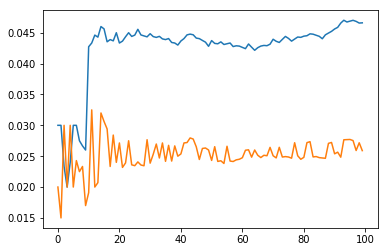

In [424]:
plt.plot(predict_rewords)
plt.plot(batch_rewords)